In [ ]:
%reset -f

import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import time

#    ====================| NRxx |==========================
# τmax = Ni /(2 * fmax )
def NRxx(SoC, T, Ts):
  n = (int)(T/Ts) + 1
  rxx = []
  for k in range(n):
    temp = 0
    for i in range(k, n):             #Sobreposição das series
      temp += SoC[i-k]*np.conj(SoC[i])/(np.absolute(SoC[i-k])*np.absolute(np.conj(SoC[i])))
    rxx.append(temp/(n))
  return np.array(rxx)

#    ====================| IRxx |==========================
def IRXX(sig, freq_m, T, Ts):
  tal = np.linspace(0, T, (int)(T/Ts) + 1)
  irxx = []
  for t_i in tal:
    irxx.append((sig**2) * special.jv(0, 2*np.pi*freq_m*t_i, out=None) )

  return np.array(irxx)


#    ====================|  Rxx  |=========================
def RXX(mod, freq, T, Ts, N = 10):
  rxx = []
  tal = np.linspace(0, T, (int)(T/Ts) + 1)
  for t_i in tal:
    temp = 0
    for n in range(N):
      temp += np.cos(2*np.pi*freq[n]*t_i)*(mod[n]**2)/2
    rxx.append(temp)
  return np.array(rxx)


#     ====================|  Phas |========================
def Rand_PHAS(N):
  phas = np.random.default_rng().uniform(0,2 * np.pi, N)
  return phas


#    ======================| MEDS |========================
def MEDS(sig, freq_m, N = 10):
  mod = []
  freq = []
  for i in range(1, N+1):
    mod.append(sig * (2 / N)**0.5)
    freq.append(freq_m * np.cos(2 * np.pi * (i - 0.25) / N))
  return np.array(mod), np.array(freq)


#    ======================| GMEA |=======================
def GMEA(sig, F, N):
  #   JAKES
  mod = np.ones(N)*sig * (2 / N)**0.5
  freq = F*np.sin((np.arange(1, N+1) - 0.5)*np.pi/(2*N))
  return mod, freq


#    ======================| LPNM |=======================
def LPNM(sig, F, T, Ts, N = 10):
  mod, freq = GMEA(sig, F, N)     #Para distribuições gaussianas a GMEA retorna
  for i in range(1, N+1):         #valores de frequencia bem ajustados
    E = np.sum((IRXX(sig, F, T, Ts) - RXX(mod, freq, T, Ts, N))**2)**0.5

  return E


#     ====================|  SoC  |========================
def SoC(mod, freq, phas, T, Ts, N = 10):
  t = np.linspace(0, T, (int)(T/Ts) + 1)
  soc = []

  for t_i in t:
    temp = 0
    for i in range(N):
      temp += complex(mod[i], 0) * np.exp(complex(0, 2 * np.pi * freq[i] * t_i + phas[i]))
    soc.append(temp)
  return np.array(soc)

In [ ]:
#    |============| |SOMA DE CISOIDES| |=================|
N = 40
T = 1
Ts = 0.001
tal = 0.25

F = 91
sig = 1

#    |============| |CORRELAÇÃO IDEAL| |=================|
irxx = IRXX(sig, F, tal, Ts)            # JAKES

#    |==================| |LPNM| |=======================|
#mod, freq = LPNM(sig, F, N)
#rxx2 = RXX(mod, freq, T, Ts, N)


#    |==================| |GMEA| |=======================|
mod, freq = GMEA(sig, F, N)
rxx1 = RXX(mod, freq, tal, Ts, N)       # GMEA

#    C++
#rxx1 = np.array([1,0.919925,0.698848,0.389133,0.06253,-0.208565,-0.369588,-0.396991,-0.302686,-0.128775,0.0656385,0.221606,0.296521,0.274835,0.170528,0.0210237,-0.125303,-0.224091,-0.247964,-0.193778,-0.0822976,0.0492892,0.159436,0.215086,0.201392,0.125491,0.0134248,-0.098602,-0.175755,-0.195266,-0.153046,-0.0643188,0.0417284,0.131441,0.177283,0.166215,0.103324,0.00973678,-0.084411,-0.149608,-0.166163,-0.1301,-0.054017,0.0372577,0.114718,0.154352,0.144552,0.0894722,0.00738813,-0.0753295,-0.132654,-0.147061,-0.114859,-0.04708,0.0342695,0.103325,0.138562,0.129486,0.0797348,0.0056855,-0.0689127,-0.120537,-0.133288,-0.103773,-0.0419712,0.0321209,0.0949416,0.126842,0.118218,0.0723878,0.00435463,-0.064089,-0.11133,-0.122748,-0.0952281,-0.0379874,0.0304995,0.0884522,0.117701,0.109373,0.066575])


#    |==================| |MEDS| |=======================|

mod, freq = MEDS(sig, F, N)
rxx2 = RXX(mod, freq, tal, Ts, N)       #MEDS



In [ ]:
#    |==========| |GERA SOC NUMERICA| |==================|
mod, freq = GMEA(sig, F, N)
phas = phas = Rand_PHAS(N)
soc1 = SoC(mod, freq, phas, T, Ts, N)
rxx = NRxx(soc1, tal, Ts)


for i in range(100):
  phas = Rand_PHAS(N)
  soc1 += SoC(mod, freq, phas, T, Ts, N)
  soc1 /= 2
nrxx1 = NRxx(soc1, tal, Ts)

mod, freq = MEDS(sig, F, N)
phas = phas = Rand_PHAS(N)
soc2 = SoC(mod, freq, phas, T, Ts, N)
rxx = NRxx(soc2, tal, Ts)


for i in range(100):
  phas = Rand_PHAS(N)
  soc2 += SoC(mod, freq, phas, T, Ts, N)
  soc2 /= 2
nrxx2 = NRxx(soc2, tal, Ts)

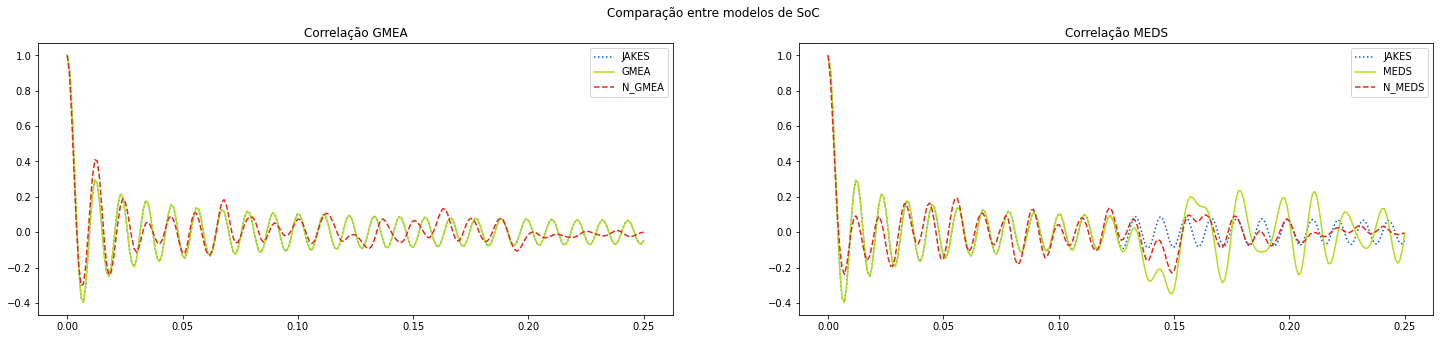

In [ ]:
#    |===============| |RESULTADOS| |====================|
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (25, 5))
fig.suptitle('Comparação entre modelos de SoC')
ax1.plot(np.linspace(0, tal, (int)(tal/Ts) + 1), irxx, '#015BE0', ls='dotted')
ax1.plot(np.linspace(0, tal, (int)(tal/Ts + 1)), rxx1, '#B0E016', ls='solid')
ax1.plot(np.linspace(0, tal, (int)(tal/Ts) + 1), nrxx1.real, '#E02E16', ls='dashed')
ax1.set_title('Correlação GMEA')
ax1.legend(['JAKES', 'GMEA', 'N_GMEA'])

ax2.plot(np.linspace(0, tal, (int)(tal/Ts) + 1), irxx, '#015BE0', ls='dotted')
ax2.plot(np.linspace(0, tal, (int)(tal/Ts) + 1), rxx2, '#B0E016', ls='solid')
ax2.plot(np.linspace(0, tal, (int)(tal/Ts) + 1), nrxx2.real, '#E02E16', ls='dashed')

ax2.set_title('Correlação MEDS')
ax2.legend(['JAKES', 'MEDS', 'N_MEDS'])

plt.show()


160


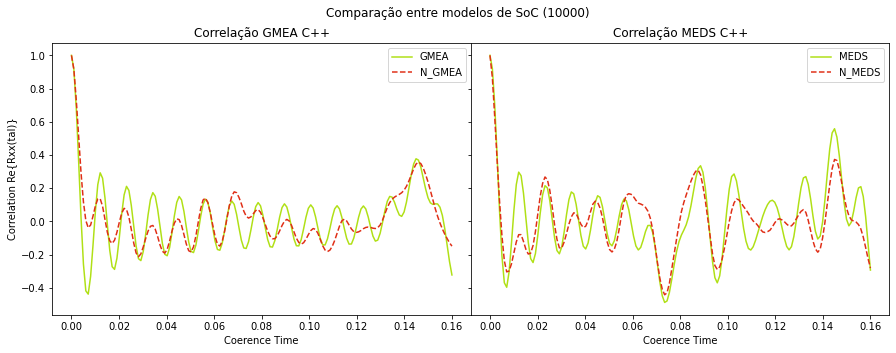

In [ ]:
rxx1 = np.array([1,0.915948,0.684207,0.360533,0.0211154,-0.257573,-0.418551,-0.438287,-0.331131,-0.143273,0.0617467,0.221606,0.29246,0.260051,0.141772,-0.0205091,-0.174353,-0.273009,-0.28914,-0.222068,-0.0966531,0.0454811,0.159434,0.210938,0.186465,0.0965801,-0.0282255,-0.147695,-0.224626,-0.236322,-0.181179,-0.0785324,0.0380032,0.131437,0.173048,0.151143,0.0742583,-0.0320303,-0.133545,-0.198433,-0.207098,-0.158078,-0.0680891,0.0336147,0.11471,0.150029,0.129337,0.0602514,-0.0344952,-0.124505,-0.18143,-0.187875,-0.142681,-0.0610112,0.0307076,0.103312,0.13415,0.114126,0.0503593,-0.0363132,-0.118127,-0.169264,-0.17398,-0.131439,-0.0557617,0.0286394,0.0949237,0.122341,0.102713,0.0428577,-0.037759,-0.113342,-0.160008,-0.163318,-0.122737,-0.0516377,0.0270975,0.0884279,0.113109,0.0937215,0.0368905,-0.0389656,-0.109596,-0.152661,-0.154789,-0.115723,-0.0482652,0.0259103,0.0832124,0.10563,0.086386,0.0319779,-0.040007,-0.106571,-0.146646,-0.147757,-0.109899,-0.0454249,0.0249745,0.0789102,0.099407,0.0802424,0.0278284,-0.0409267,-0.104069,-0.141602,-0.141818,-0.104942,-0.0429677,0.0242409,0.0753127,0.0941628,0.0750572,0.0243552,-0.0415964,-0.101722,-0.136939,-0.136189,-0.0998914,-0.0397149,0.0252135,0.0744454,0.0927283,0.0748329,0.0271716,-0.0342833,-0.0890961,-0.118841,-0.11289,-0.0716808,-0.00645143,0.0644561,0.12152,0.150295,0.146004,0.115016,0.0727505,0.0386911,0.0300965,0.0564127,0.116148,0.197184,0.280416,0.345528,0.377104,0.369109,0.326377,0.262666,0.19594,0.142441,0.111449,0.102438,0.105531,0.105096,0.085331,0.0360351,-0.0433147,-0.142506,-0.242947,-0.322743])
nrxx1 = np.array([1,0.91543,0.73203,0.508563,0.291761,0.116835,0.00499007,-0.0381367,-0.0219991,0.0315751,0.0934849,0.134931,0.135944,0.0910096,0.0118097,-0.0660432,-0.116758,-0.132959,-0.113265,-0.0654308,-0.00474596,0.0493367,0.0785072,0.0712099,0.0259485,-0.0477875,-0.129188,-0.189945,-0.212744,-0.196036,-0.153952,-0.103612,-0.0587078,-0.0296683,-0.0247223,-0.0469939,-0.0907779,-0.141749,-0.180492,-0.190906,-0.16867,-0.11894,-0.0590758,-0.0104569,0.0152869,0.0105244,-0.0243028,-0.0792144,-0.136765,-0.176855,-0.184293,-0.153245,-0.0876929,-0.00326348,0.0764993,0.128729,0.140582,0.113355,0.054345,-0.0195273,-0.0896177,-0.13715,-0.148853,-0.120622,-0.0591577,0.0198153,0.0960934,0.152263,0.177838,0.172783,0.144405,0.10609,0.0623916,0.0314428,0.0198772,0.0271383,0.046032,0.0649933,0.0710167,0.0549399,0.0212395,-0.0200448,-0.0593131,-0.0888396,-0.104474,-0.104592,-0.0867805,-0.0573235,-0.0250062,0.000874818,0.0117998,0.00271986,-0.0254109,-0.0643523,-0.101551,-0.126929,-0.136891,-0.128885,-0.107319,-0.0799335,-0.0557669,-0.0431261,-0.0480665,-0.0722726,-0.109543,-0.147184,-0.173009,-0.181814,-0.173308,-0.150002,-0.11501,-0.0726128,-0.0288545,0.00353892,0.0130634,0.00238242,-0.0211308,-0.0459186,-0.0620479,-0.0664149,-0.0632206,-0.0549293,-0.0440845,-0.0366157,-0.0340765,-0.036653,-0.0410926,-0.0430341,-0.0378081,-0.0217576,0.00731281,0.0465408,0.0835418,0.113033,0.133314,0.146148,0.155029,0.162694,0.172514,0.187963,0.211315,0.242529,0.279072,0.315948,0.345291,0.356929,0.34806,0.321222,0.28307,0.237523,0.186057,0.131133,0.0783187,0.0309911,-0.0096064,-0.0453876,-0.0764382,-0.103803,-0.129154,-0.149142])

rxx2 = np.array([1,0.919925,0.698847,0.389133,0.06253,-0.208565,-0.369588,-0.396991,-0.302686,-0.128775,0.0656385,0.221606,0.296521,0.274835,0.170528,0.0210237,-0.125303,-0.224091,-0.247964,-0.193778,-0.0822977,0.0492892,0.159436,0.215086,0.201392,0.125491,0.0134248,-0.098602,-0.175755,-0.195266,-0.153046,-0.0643189,0.0417283,0.131441,0.177283,0.166215,0.103324,0.00973685,-0.0844109,-0.149608,-0.166163,-0.130101,-0.054018,0.0372557,0.114714,0.154344,0.144536,0.0894411,0.00733008,-0.0754355,-0.132844,-0.147392,-0.115425,-0.0480272,0.0327176,0.100834,0.134646,0.123454,0.0706256,-0.00779801,-0.0884785,-0.14837,-0.172104,-0.156834,-0.113057,-0.0611899,-0.0250256,-0.024156,-0.0677299,-0.151475,-0.258853,-0.365927,-0.448357,-0.488331,-0.479288,-0.427053,-0.347158,-0.259327,-0.181013,-0.122095,-0.0824422,-0.0531037,-0.0206312,0.0269429,0.0945381,0.176808,0.258469,0.318226,0.335194,0.295842,0.199284,0.059176,-0.0985404,-0.241553,-0.339165,-0.370134,-0.328163,-0.223517,-0.0803479,0.0694712,0.194263,0.270034,0.285569,0.243956,0.160399,0.0572355,-0.0422307,-0.119283,-0.163316,-0.172655,-0.152882,-0.113614,-0.0650162,-0.015226,0.0306438,0.0699284,0.100892,0.121217,0.127392,0.115437,0.0828044,0.0306969,-0.0342643,-0.0999758,-0.150865,-0.171705,-0.152238,-0.0911477,0.00205672,0.108194,0.202649,0.261772,0.269706,0.22363,0.135679,0.0307019,-0.0598181,-0.106169,-0.0888433,-0.00456413,0.131949,0.291185,0.436295,0.532831,0.558075,0.507289,0.395068,0.251309,0.112871,0.0132423,-0.0268522,-0.00521696,0.0613532,0.142086,0.201318,0.209073,0.150116,0.0288869,-0.131123,-0.29339])
nrxx2 = np.array([1,0.864996,0.625913,0.365772,0.120859,-0.0863998,-0.237376,-0.304232,-0.298589,-0.255143,-0.188856,-0.123831,-0.0800934,-0.0800193,-0.120592,-0.167718,-0.196695,-0.191831,-0.145581,-0.0612229,0.0476553,0.151642,0.228804,0.267454,0.251187,0.187189,0.0891065,-0.0213526,-0.10858,-0.159095,-0.160696,-0.124067,-0.0729548,-0.016772,0.027054,0.0513079,0.0471069,0.015711,-0.0175348,-0.0369943,-0.0294479,0.0044109,0.0572068,0.103553,0.12184,0.114332,0.0805615,0.0232737,-0.0488783,-0.124076,-0.169969,-0.184131,-0.166391,-0.121582,-0.0461289,0.0421463,0.11759,0.157976,0.16657,0.162891,0.148201,0.126905,0.109662,0.104518,0.0971935,0.0842243,0.0617908,0.0194945,-0.0496601,-0.144216,-0.248945,-0.343189,-0.408911,-0.442103,-0.430442,-0.371544,-0.284638,-0.193067,-0.104555,-0.0181249,0.0583065,0.113202,0.158437,0.20143,0.242082,0.277436,0.301987,0.308396,0.280864,0.214051,0.125834,0.0183795,-0.0925501,-0.195149,-0.266153,-0.28997,-0.274095,-0.228735,-0.160622,-0.0834284,-0.00124394,0.0649795,0.111002,0.134873,0.129776,0.110138,0.0889804,0.0694112,0.0477004,0.0225875,0.00214048,-0.0092706,-0.0262652,-0.047048,-0.0636117,-0.067038,-0.0619663,-0.053479,-0.0335215,-0.00939121,0.0104881,0.0159916,0.00906836,-0.00147469,-0.0162702,-0.0284005,-0.0269001,-0.0109102,0.0146413,0.0395312,0.0602673,0.0708155,0.0544549,0.00674276,-0.0564657,-0.118582,-0.165639,-0.185609,-0.167062,-0.101122,-0.00415129,0.108047,0.221622,0.317249,0.372994,0.366867,0.310827,0.232804,0.150659,0.0805718,0.0340754,0.00966331,0.00153162,-0.00418234,-0.0188816,-0.0460916,-0.0943056,-0.15728,-0.223698,-0.28098])

print(len(rxx))
tal = 0.16
Ts = 0.001
#    |===============| |RESULTADOS c++| |====================|
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'wspace': 0}, figsize = (15, 5))
fig.suptitle('Comparação entre modelos de SoC (10000)')
ax1.plot(np.linspace(0, tal, (int)(tal/Ts)), rxx1, '#B0E016', ls='solid')
ax1.plot(np.linspace(0, tal, (int)(tal/Ts)), nrxx1.real, '#E02E16', ls='dashed')
ax1.set_title('Correlação GMEA C++')
ax1.set_xlabel('Coerence Time')
ax1.set_ylabel('Correlation Re{Rxx(tal)}')
ax1.legend(['GMEA', 'N_GMEA', 'N_GMEA'])

ax2.plot(np.linspace(0, tal, (int)(tal/Ts)), rxx2, '#B0E016', ls='solid')
ax2.plot(np.linspace(0, tal, (int)(tal/Ts)), nrxx2.real, '#E02E16', ls='dashed')

ax2.set_title('Correlação MEDS C++')
ax2.set_xlabel('Coerence Time')
ax2.legend(['MEDS', 'N_MEDS', 'N_MEDS'])

plt.show()